In [7]:
#input necessary packages here
import os

os.environ['PROJ_LIB'] = '/Users/cjmasiel/opt/anaconda3/share/proj'

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

#wrf packages
import wrf
from wrf import (to_np, interplevel, geo_bounds, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, getvar, CoordPair, vertcross, ll_to_xy, xy_to_ll)

#to read in data
import glob
import matplotlib.pyplot as plt

#for some fun math
import math
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from netCDF4 import Dataset, num2date, date2num
from scipy.ndimage import gaussian_filter

In [9]:
#only run the cell below for the 1.33 kilometer inner nest

#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tclon, tclat, ax=None):
    tclon5a = 5 * (int(tclon / 5) - 1)
    tclon5b = 5 * (int(tclon / 5))
    tclat5a = 5 * (int(tclat / 5) - 1)
    tclat5b = 5 * (int(tclat / 5))

    if ax is None:
        fig = plt.figure(figsize=(15, 15))
        ax = plt.subplot(111, projection=ccrs.PlateCarree())
    else:
        fig = None

    ax.set_extent([tclon - 7, tclon + 7, tclat - 7, tclat + 7], ccrs.PlateCarree())
    gl = ax.gridlines(color='gray', alpha=0.5, draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a - 10, tclon5a - 5, tclon5a, tclon5b, tclon5b + 5, tclon5b + 10])
    gl.ylocator = mticker.FixedLocator([tclat5a - 10, tclat5a - 5, tclat5a, tclat5b, tclat5b + 5, tclat5b + 10])
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)

    return fig, ax

In [11]:
#First, Specifiy File path
filepath = '/Users/cjmasiel/Desktop/Anantha_Final/real_plane/wrfout_d02_files/wrfout_d02*' 
datafiles = sorted(glob.glob(filepath))

In [13]:
# set some constants for later use that we may or may not use, just there for any meteorological claculation you may conduct
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50
k          = 0.4          #Von Karmen Constant

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [15]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000., 99000., 98000., 97000., 96000., 95000., 94000., 93000., 92000., 91000.,
           90000., 89000., 88000., 87000., 86000., 85000., 84000., 83000., 82000., 81000., 80000.,
           77500., 75000., 72500., 70000., 67500., 65000., 62500., 60000., 57500., 55000., 52500.,
           50000., 47500., 45000., 42500., 40000., 37500., 35000., 32500., 30000., 27500., 25000.,
           22500., 20000., 17500., 15000., 12500., 10000., 7500., 6000.]

#Vertical levels we are considering for azimuthal averages 
zlevs = [ 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
         1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2250.,
         2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750., 5000.,
         5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000., 9500., 10000., 10500.,
         11000., 11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
         16000., 16500., 17000., 17500., 18000., 18500.]

nlevs   = len(plevs) #level of interest is 850 hPa, which is the sixth level
n_zlevs = len(zlevs)

print("Number of Pressure levels in the vertical", nlevs)
print("Number of height levels in the vertical", n_zlevs)
yplabs = ['']*nlevs
yzlabs = ['']*n_zlevs

Number of Pressure levels in the vertical 51
Number of height levels in the vertical 68


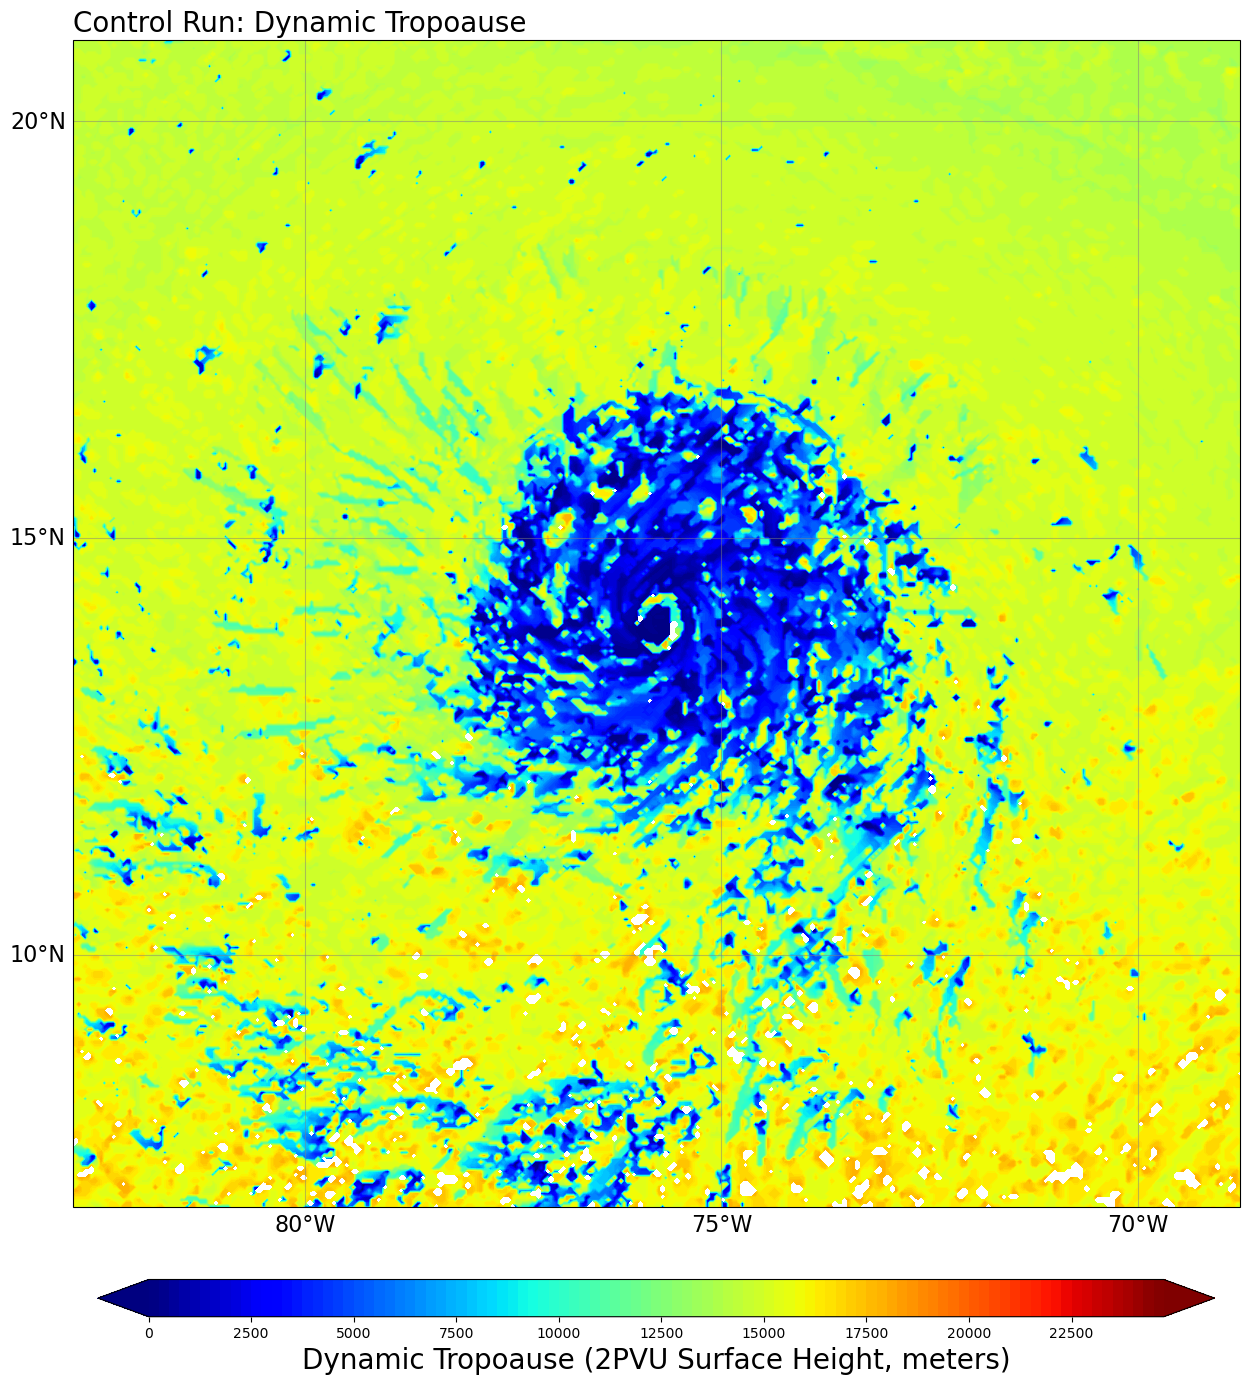

In [47]:
for item in range(15,16):
    ncfile = Dataset(datafiles[item])
    wrf_out_data = xr.open_dataset(datafiles[item])   
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    # Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    # Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values

    #fig, ax = create_map_background(tc_lon,tc_lat) #We are only looking at 11 indices, and our list goes from 0-11, not 24 and up
    #####################################################################################################################################
    #now that we have center information, we can do momentum calculation

    #constants
    lats = getvar(ncfile, "XLAT")
    lons = getvar(ncfile, "XLONG") 
    land = getvar(ncfile, "LANDMASK")
    ptop = getvar(ncfile, "P_TOP")

    nx = lats.shape[0]
    ny = lats.shape[1]
    nz = P_pertubation.shape[1]

    #variables we will need for momentum calculations
    # Get variables 
    z_height  = getvar(ncfile, "z")
    pv        = getvar(ncfile, "pvo")

    pvgrd, zgrd = [np.zeros([nx,ny,n_zlevs]) for _ in range(2)]

    for k in range(n_zlevs):
        clev = zlevs[k]

        #Do vertical interpolation to specified pressure surfaces (in hPa)
        pvp   = interplevel(pv, z_height, clev)
        zz    = interplevel(z_height, z_height, clev)
        
        pvgrd[:,:,k] = pvp[:,:]
        zgrd[:,:,k] = zz[:,:]
    ######################################################################################################################################
    tropopause_height = np.full([nx, ny], np.nan)

    #Create a boolean array where the transition occurs
    transition = (pvgrd[:, :, :-1] <= 2.0) & (pvgrd[:, :, 1:] > 2.0)
    
    #Find the first occurrence of the transition along the vertical axis
    k_indices = np.argmax(transition, axis=2)
    
    #Index into the height array to find the tropopause height
    tropopause_height = zgrd[np.arange(nx)[:, None], np.arange(ny), k_indices]

    #############################################################################################################
    fig, ax = create_map_background(tc_lon,tc_lat)
    
    plot = plt.contourf(lons, lats, tropopause_height,
                        origin = 'lower', 
                        cmap = 'jet', 
                        levels = np.arange(0, 25000, 250), 
                        alpha = 1, 
                        extend ='both')
    

    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('Dynamic Tropoause (2PVU Surface Height, meters)', fontsize = 20)
    
    #plt.legend(loc='upper right', fontsize=24, framealpha=1)
 
    plt.title('Control Run: Dynamic Tropoause Height', loc = 'left', fontsize = 20)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    plt.show()
    plt.close()

In [ ]:
for item in range(15,16):
    ncfile = Dataset(datafiles[item])
    wrf_out_data = xr.open_dataset(datafiles[item])   
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    # Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    # Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values

    #fig, ax = create_map_background(tc_lon,tc_lat) #We are only looking at 11 indices, and our list goes from 0-11, not 24 and up
    #####################################################################################################################################
    #now that we have center information, we can do momentum calculation

    #constants
    lats = getvar(ncfile, "XLAT")
    lons = getvar(ncfile, "XLONG") 
    land = getvar(ncfile, "LANDMASK")
    ptop = getvar(ncfile, "P_TOP")

    nx = lats.shape[0]
    ny = lats.shape[1]
    nz = P_pertubation.shape[1]

    #variables we will need for momentum calculations
    # Get variables 
    z_height  = getvar(ncfile, "z")
    pv        = getvar(ncfile, "pvo")
    pot       = getvar(ncfile, "th")

    pvgrd, zgrd,potgrd = [np.zeros([nx,ny,n_zlevs]) for _ in range(3)]

    for k in range(n_zlevs):
        clev = zlevs[k]

        #Do vertical interpolation to specified pressure surfaces (in hPa)
        pvp   = interplevel(pv, z_height, clev)
        zz    = interplevel(z_height, z_height, clev)
        potz  = interplevel(pot, z_height, clev)
        
        pvgrd[:,:,k]  = pvp[:,:]
        zgrd[:,:,k]   = zz[:,:]
        potgrd[:,:,k] = potz[:,:]
    ######################################################################################################################################
    tropopause_height = np.full([nx, ny], np.nan)

    #Create a boolean array where the transition occurs
    transition = (pvgrd[:, :, :-1] <= 2.0) & (pvgrd[:, :, 1:] > 2.0)
    
    #Find the first occurrence of the transition along the vertical axis
    k_indices = np.argmax(transition, axis=2)
    
    #Index into the height array to find the tropopause height
    tropopause_height = zgrd[np.arange(nx)[:, None], np.arange(ny), k_indices]
    ######################################################################################################################################
    #now, we want to plot the potential temperature on the dynamic tropopause surface
    potgrd_on_tropopause = potgrd[np.arange(nx)[:, None], np.arange(ny), k_indices]

    #############################################################################################################
    fig, ax = create_map_background(tc_lon,tc_lat)
    
    plot = plt.contourf(lons, lats, potgrd_on_tropopause,
                        origin = 'lower', 
                        cmap = 'plasma', 
                        levels = np.arange(260, 384, 6), 
                        alpha = 1, 
                        extend ='both')
    

    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('Potential Temperature on 2PVU Surface (Kelvin)', fontsize = 20)
    
    #plt.legend(loc='upper right', fontsize=24, framealpha=1)
 
    plt.title('Control Run: Potential Temperature on 2PVU Surface', loc = 'left', fontsize = 20)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    plt.show()
    plt.close()